<a href="https://colab.research.google.com/github/jyotikashyap85399-tech/Image-classification/blob/main/CV_assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0 - imports and setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from pathlib import Path

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# Cell 1 - transforms
# Using grayscale to 3-channel conversion as in the assignment
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])


In [3]:
!pip install kaggle


In [12]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"jyotikashyap01","key":"1928bd8cab3562495f145babb7206eef"}'}

In [14]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [17]:
!kaggle datasets download -d jessicali9530/caltech256 -p /content/data


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/caltech256
License(s): other
 99% 2.10G/2.12G [00:23<00:00, 38.8MB/s]
100% 2.12G/2.12G [00:23<00:00, 97.3MB/s]


In [18]:
!unzip /content/data/caltech256.zip -d /content/data


Streaming output truncated to the last 5000 lines.
  inflating: /content/data/256_objectcategories/256_ObjectCategories/228.triceratops/228_0077.jpg  
  inflating: /content/data/256_objectcategories/256_ObjectCategories/228.triceratops/228_0078.jpg  
  inflating: /content/data/256_objectcategories/256_ObjectCategories/228.triceratops/228_0079.jpg  
  inflating: /content/data/256_objectcategories/256_ObjectCategories/228.triceratops/228_0080.jpg  
  inflating: /content/data/256_objectcategories/256_ObjectCategories/228.triceratops/228_0081.jpg  
  inflating: /content/data/256_objectcategories/256_ObjectCategories/228.triceratops/228_0082.jpg  
  inflating: /content/data/256_objectcategories/256_ObjectCategories/228.triceratops/228_0083.jpg  
  inflating: /content/data/256_objectcategories/256_ObjectCategories/228.triceratops/228_0084.jpg  
  inflating: /content/data/256_objectcategories/256_ObjectCategories/228.triceratops/228_0085.jpg  
  inflating: /content/data/256_objectcategories/2

In [19]:
import os
os.listdir("/content/data/256_ObjectCategories")[:10]


['079.frisbee',
 '037.chess-board',
 '208.swiss-army-knife',
 '182.self-propelled-lawn-mower',
 '102.helicopter-101',
 '206.sushi',
 '251.airplanes-101',
 '167.pyramid',
 '176.saddle',
 '241.waterfall']

In [20]:
# Cell 2 - Dataset / DataLoader
# IMPORTANT: place the Caltech-256 folder path here
# Typical folder name after extraction: "256_ObjectCategories" which contains 257 subfolders (000..256)
# Option A: If you have uploaded/extracted dataset to /content/256_ObjectCategories, use that.
# Option B: Change data_dir to your path.
data_dir =("/content/data/256_ObjectCategories")
  # <-- change if needed

# If dataset is not present, add code to download/extract it here (commented).
# Example (uncomment and adapt if you have a direct URL):
# !wget <URL-to-256_ObjectCategories-zip> -O /content/caltech256.zip
# !unzip /content/caltech256.zip -d /content/

# Use ImageFolder; split into train/test (simple split because dataset has no official train/test)
# We'll create a reproducible split: for each class, use 80% images for train, 20% for test.
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

assert os.path.exists(data_dir), f"data_dir not found: {data_dir}. Please upload/extract Caltech-256 there."

# Build list of image paths and labels, then split
full_dataset = ImageFolder(root=data_dir, transform=None)
classes = full_dataset.classes
print("Number classes found:", len(classes))  # should be 257 (including '257'? depends on naming)

# Create lists of file paths and labels
paths = [p for (p, _) in full_dataset.samples]
labels = [l for (_, l) in full_dataset.samples]

# Map each class separately to ensure per-class split
train_paths = []
train_labels = []
test_paths = []
test_labels = []

from collections import defaultdict
class_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(full_dataset.samples):
    class_to_indices[label].append(idx)

for label, idx_list in class_to_indices.items():
    train_idx, test_idx = train_test_split(idx_list, test_size=0.2, random_state=42, shuffle=True)
    for i in train_idx:
        train_paths.append(full_dataset.samples[i][0])
        train_labels.append(full_dataset.samples[i][1])
    for i in test_idx:
        test_paths.append(full_dataset.samples[i][0])
        test_labels.append(full_dataset.samples[i][1])

# Create custom ImageFolder-like datasets using ImageFolder but overriding samples
from PIL import Image
from torch.utils.data import Dataset

class SubsetImageFolder(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples   # list of (path, label)
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, label = self.samples[index]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# build sample tuples
train_samples = list(zip(train_paths, train_labels))
test_samples = list(zip(test_paths, test_labels))

train_dataset = SubsetImageFolder(train_samples, transform=transform_train)
test_dataset = SubsetImageFolder(test_samples, transform=transform_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Train images:", len(train_dataset), "Test images:", len(test_dataset))

Number classes found: 257
Train images: 24385 Test images: 6222


In [21]:
# Cell 3 - Load pretrained ResNet-18 and modify final layer
model = models.resnet18(pretrained=True)

# Freeze all parameters except final fc by default
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to output 257 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))  # len(classes) should be 257
# The new fc parameters will have requires_grad=True by default
model = model.to(device)

print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Cell 4 - Loss and optimizer
criterion = nn.CrossEntropyLoss()
# Only optimize parameters which require gradients (fc layer)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


In [23]:
# Cell 5 - Training + evaluation function
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()
    best_model_wts = None
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                # Move to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy best model (based on test/val accuracy)
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best test Acc: {best_acc:.4f}')

    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    return model

# Fine-tune only the final layer for a few epochs
fine_tuned_model = train_model(model, criterion, optimizer, num_epochs=5)


Epoch 1/5
--------------------
train Loss: 3.0742 Acc: 0.3954
test Loss: 1.4605 Acc: 0.6681

Epoch 2/5
--------------------
train Loss: 1.8417 Acc: 0.5855
test Loss: 1.2002 Acc: 0.7001

Epoch 3/5
--------------------
train Loss: 1.6443 Acc: 0.6186
test Loss: 1.1444 Acc: 0.7136

Epoch 4/5
--------------------
train Loss: 1.5626 Acc: 0.6336
test Loss: 1.1720 Acc: 0.7032

Epoch 5/5
--------------------
train Loss: 1.5055 Acc: 0.6433
test Loss: 1.0757 Acc: 0.7282

Training complete in 12m 9s
Best test Acc: 0.7282


In [24]:
# Cell 6 - helper: denormalize and class mapping
def denormalize(image_tensor):
    """Assumes image_tensor is normalized with mean/std used above and shape C,H,W"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image_tensor.clone().cpu().permute(1, 2, 0).numpy()
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

def make_map_classes(path):
    classes_dir = os.listdir(path)
    classes_dir.sort()
    classes_dict = {}
    # In caltech-256 folder, folder names start like '001.ak47', '002.american-flag', ...
    for c in classes_dir:
        # try robust parsing: index = int(prefix before dot)
        parts = c.split('.', 1)
        try:
            index = int(parts[0]) - 1  # map to zero-based label (folder 001 -> 0)
            name = parts[1] if len(parts) > 1 else parts[0]
            classes_dict[index] = name
        except:
            # fallback: assign next integer
            classes_dict[len(classes_dict)] = c
    return classes_dict

classes_dict = make_map_classes(data_dir)
print("Sample mapping (0..4):", {k: classes_dict[k] for k in sorted(classes_dict)[:5]})


Sample mapping (0..4): {0: 'ak47', 1: 'american-flag', 2: 'backpack', 3: 'baseball-bat', 4: 'baseball-glove'}


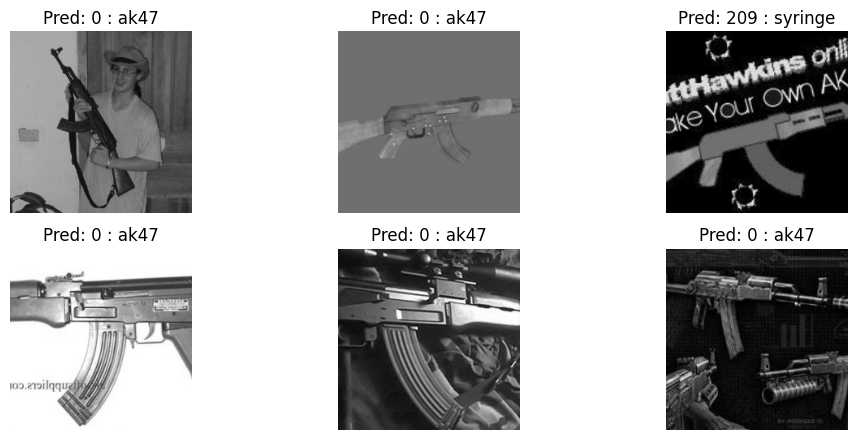

In [25]:
# Cell 7 - visualize_predictions
def visualize_predictions(model, dataloader, num_images=6):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images//3 + 1, 3, images_so_far)
                ax.axis('off')
                title = f'Pred: {preds[i].item()}'
                if preds[i].item() in classes_dict:
                    title += f' : {classes_dict[preds[i].item()]}'
                ax.set_title(title)
                img = denormalize(inputs[i])
                ax.imshow(img)
                if images_so_far == num_images:
                    plt.show()
                    return
    plt.show()

# Show some predictions from fine-tuned model
visualize_predictions(fine_tuned_model, test_loader, num_images=6)


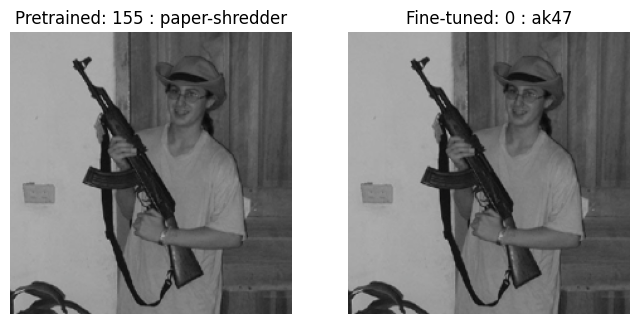

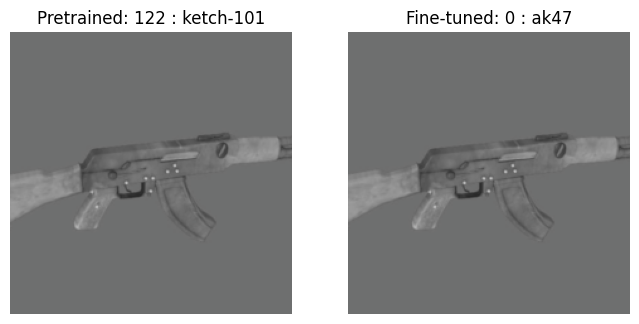

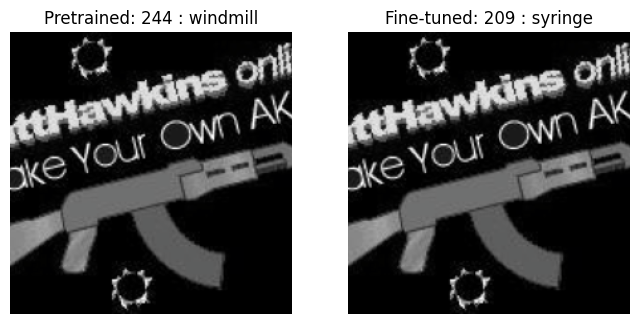

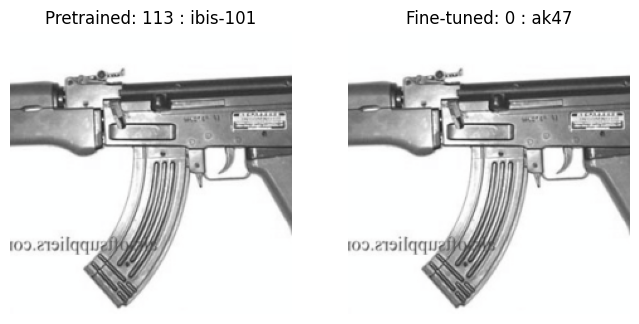

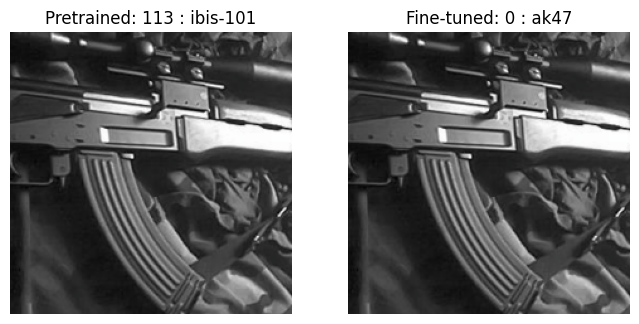

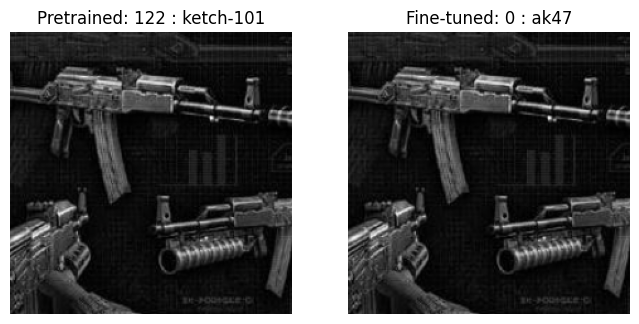

In [26]:
# Cell 8 - compare_predictions between pretrained and fine-tuned
# Build a fresh pretrained model (same architecture) for comparison (weights: imagenet)
pretrained_model = models.resnet18(pretrained=True)
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, len(classes))
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

def compare_predictions(pretrained_model, finetuned_model, dataloader, path_dir, num_images=5):
    pretrained_model.eval()
    finetuned_model.eval()
    images_shown = 0
    classes_dict = make_map_classes(path_dir)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            pre_outputs = pretrained_model(inputs)
            _, pre_preds = torch.max(pre_outputs, 1)

            fin_outputs = finetuned_model(inputs)
            _, fin_preds = torch.max(fin_outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown == num_images:
                    return
                images_shown += 1
                img = denormalize(inputs[i])

                plt.figure(figsize=(8, 4))

                plt.subplot(1, 2, 1)
                plt.imshow(img)
                pidx = pre_preds[i].item()
                title = f'Pretrained: {pidx}'
                if pidx in classes_dict:
                    title += f' : {classes_dict[pidx]}'
                plt.title(title)
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(img)
                fidx = fin_preds[i].item()
                title = f'Fine-tuned: {fidx}'
                if fidx in classes_dict:
                    title += f' : {classes_dict[fidx]}'
                plt.title(title)
                plt.axis('off')

                plt.show()

# Run comparison
compare_predictions(pretrained_model, fine_tuned_model, test_loader, data_dir, num_images=6)


In [27]:
# Cell 9: learning rate scheduler + unfreeze last layers (advanced)
from torch.optim import SGD
from torch.optim import lr_scheduler

# Example: unfreeze layer4 and fc
def unfreeze_last_layers(model, layers_to_unfreeze = ['layer4']):
    for name, child in model.named_children():
        if name in layers_to_unfreeze or name == 'fc':
            for param in child.parameters():
                param.requires_grad = True

# Unfreeze layer4 and fc for further fine-tuning
unfreeze_last_layers(fine_tuned_model, layers_to_unfreeze=['layer4'])

# New optimizer: only parameters with requires_grad=True
params_to_optimize = filter(lambda p: p.requires_grad, fine_tuned_model.parameters())
new_optimizer = SGD(params_to_optimize, lr=1e-4, momentum=0.9)
scheduler = lr_scheduler.StepLR(new_optimizer, step_size=3, gamma=0.1)

# Train a few more epochs with scheduler
def train_model_with_scheduler(model, criterion, optimizer, scheduler, num_epochs=3):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train','test']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = test_loader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects / len(dataloader.dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        scheduler.step()
        print()
    return model

fine_tuned_model = train_model_with_scheduler(fine_tuned_model, criterion, new_optimizer, scheduler, num_epochs=3)


Epoch 1/3
train Loss: 1.3141 Acc: 0.6851
test Loss: 0.9584 Acc: 0.7554

Epoch 2/3
train Loss: 1.2388 Acc: 0.7054
test Loss: 0.9311 Acc: 0.7613

Epoch 3/3
train Loss: 1.1964 Acc: 0.7138
test Loss: 0.9579 Acc: 0.7546

